In [190]:
import emcee
import corner
import numpy as np

from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt
from scipy.optimize import root, brentq

from load_mcxc_data import load_clusters
from cluster_functions import c
from statistics_functions import chi_squared

In [181]:
clusters, variances=load_clusters(nrows=20)

In [164]:
cls=clusters[5]

In [165]:
def radiative_cooling_rate(T_b, cluster):
    prefactors=6.8*1e-42 *u.erg*u.cm**3
    Z=1
    T=T_b.to(u.K, equivalencies=u.temperature_energy())#self.baryon_temp.to(u.K, equivalencies=u.temperature_energy())
    T8=T/(1e8*u.K)
    C=(prefactors*Z**2*(cluster.n_e.to(u.cm**-3))**2)/(T8**(1/2))
    Eff_int = (C*T*const.k_B/const.h).to(u.GeV/(u.s*u.cm**3))
    return (cluster.volume*Eff_int).to(u.erg/u.s)

In [166]:
def agn_heating_rate(T_b, cluster):
    with u.set_enabled_equivalencies(u.mass_energy()):
        return (cluster.epsilon * accretion_rate(T_b, cluster)).to(
            u.GeV / u.s, equivalencies=u.temperature_energy())

In [167]:
def accretion_rate(T_b, cluster):
    with u.set_enabled_equivalencies(u.mass_energy()):
        leading_factors = cluster.norm * 4 * np.pi * const.c**-3
        gm2 = (const.G * cluster.bh_mass) ** 2
        frac = (cluster.mu * cluster.m_b) ** (5 / 2) / cluster.adiabatic_idx ** (3 / 2)
        return leading_factors * gm2 * frac * plasma_entropy(T_b, cluster) ** (-3 / 2)

In [168]:
def plasma_entropy(T_b, cluster):
    baryon_number_density = (2 * cluster.n_e).to(u.m ** (-3))
    return (const.k_B * T_b.to(u.K, equivalencies=u.temperature_energy())
        ).to(u.GeV) / baryon_number_density ** (cluster.adiabatic_idx - 1)

In [169]:
def dm_cooling_rate(T_b, cluster, s0, m_chi=1e-2*u.GeV, n=0, f_chi=1, m_psi=0.1*u.GeV):
    dm_temp = cluster.virial_temperature(m_chi, f_chi=f_chi, m_psi=m_psi)
    uth = np.sqrt(T_b / cluster.m_b + dm_temp / m_chi)
    rho_chi = cluster.rho_dm * f_chi

    denominator = (m_chi + cluster.m_b) ** 2
    numerator = (
            3
            * (T_b - dm_temp)
            * rho_chi
            * cluster.rho_b
            * cluster.volume.to(u.cm**3)
            * c(n)
            * uth ** (n + 1)
            * (const.c.to(u.cm / u.s))
            *s0
        
        )
    
    conversion_factor = 0.197*1e-15 * (u.GeV * u.m)
    return (numerator / denominator).to(u.erg/u.s)
    

In [170]:
s0=1e-25*u.cm**2
dm_cooling_rate(cls.baryon_temp, cls, s0)

<Quantity 2.52055321e+43 erg / s>

In [171]:
radiative_cooling_rate(cls.baryon_temp, cls)

<Quantity 2.76140798e+43 erg / s>

In [172]:
agn_heating_rate(cls.baryon_temp, cls).to(u.erg/u.s)

<Quantity 7.77320035e+49 erg / s>

In [383]:
def equil(logT_b, cluster, p0):
    #divide agn_heating_rate by 1e9 to put it at the same oom as the cooling
    s0=10**p0 * u.cm**2
    T_b=10**(logT_b)*u.GeV
    
    #print(T_b, agn_heating_rate(T_b, cluster)/1e6 - dm_cooling_rate(T_b, cluster, s0) - radiative_cooling_rate(T_b, cluster))
    #print((agn_heating_rate(T_b, cluster)/1e5).to(u.erg/u.s), dm_cooling_rate(T_b, cluster, s0), radiative_cooling_rate(T_b, cluster))
    return ((agn_heating_rate(T_b, cluster)/1e5).to(u.erg/u.s) - dm_cooling_rate(T_b, cluster, s0) - radiative_cooling_rate(T_b, cluster)).value

In [384]:
#np.log10(cls.baryon_temp.value)
equil(-6, cls, -25)


2.0629352803307662e+45

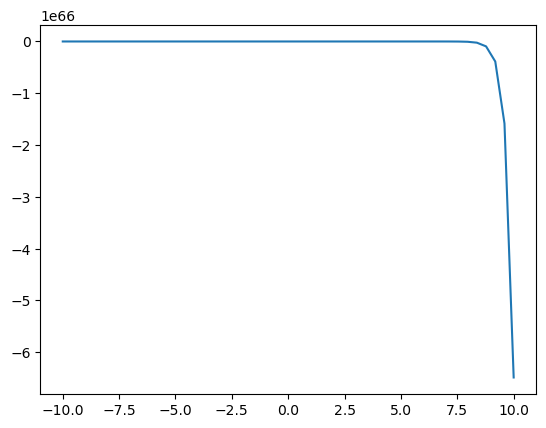

In [387]:
plt.plot(log_Tbs, equil(log_Tbs, cls, -25))

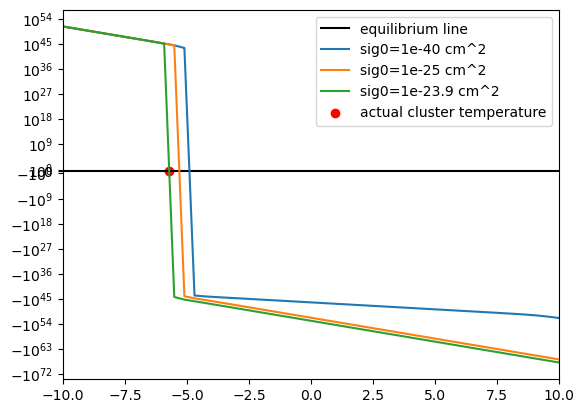

In [419]:
log_Tbs=np.linspace(-10, 10)

plt.yscale('symlog')
#plt.xscale('log')
plt.xlim(-10,10)
plt.plot([-10,10], [0,0], color='black', label='equilibrium line')

plt.plot(log_Tbs, equil(log_Tbs, cls, -40), label='sig0=1e-40 cm^2')
plt.plot(log_Tbs, equil(log_Tbs, cls, -25), label='sig0=1e-25 cm^2')
plt.plot(log_Tbs, equil(log_Tbs, cls, -23.9), label='sig0=1e-23.9 cm^2')
plt.scatter(np.log10(cls.baryon_temp.value),0, color='red', label='actual cluster temperature')
plt.legend()

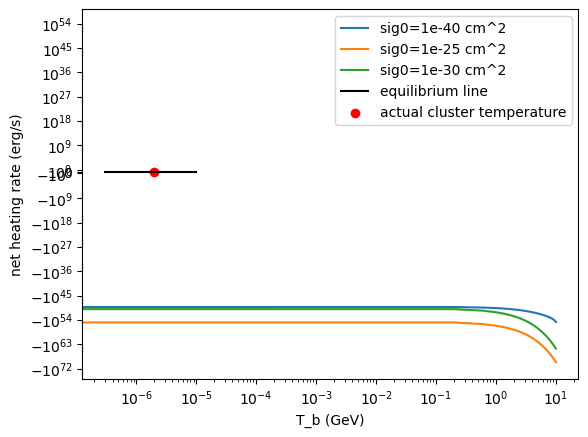

In [304]:
#T_b = np.logspace(-8, -5)*u.GeV
#s0=1e-25*u.cm**2

log_Tbs=np.linspace(-10, 10)

#plt.loglog()
plt.yscale('symlog')
plt.xscale('log')

plt.xlabel('T_b (GeV)')
plt.ylabel('net heating rate (erg/s)')

plt.plot(log_Tbs, equil(log_Tbs, cls, -40), label='sig0=1e-40 cm^2')
plt.plot(log_Tbs, equil(log_Tbs, cls, -25), label='sig0=1e-25 cm^2')
plt.plot(log_Tbs, equil(log_Tbs, cls, -30), label='sig0=1e-30 cm^2') #any lower sig0 value is basically the same as this line
#plt.plot(T_b, equil(T_b, cls, 1e-40*u.cm**2), label='sig0=1e-40 cm^2')

#plt.plot(log_Tbs, agn_heating_rate(10**log_Tbs*u.GeV, cls)/1e6)

plt.plot([3*1e-7,1e-5], [0,0], color='black', label='equilibrium line')
plt.scatter(cls.baryon_temp,0, color='red', label='actual cluster temperature')
plt.legend()

In [249]:
ys = (agn_heating_rate(10**log_Tbs*u.GeV, cls)/1e6).to(u.erg/u.s) 
- dm_cooling_rate(10**log_Tbs*u.GeV, cls, 10**-25 * u.cm**2) 
- radiative_cooling_rate(10**log_Tbs*u.GeV, cls)

<Quantity [-1.98456307e+42, -2.12949758e+42, -2.28501679e+42,
           -2.45189372e+42, -2.63095782e+42, -2.82309915e+42,
           -3.02927273e+42, -3.25050337e+42, -3.48789069e+42,
           -3.74261463e+42, -4.01594129e+42, -4.30922926e+42,
           -4.62393633e+42, -4.96162675e+42, -5.32397901e+42,
           -5.71279421e+42, -6.13000494e+42, -6.57768497e+42,
           -7.05805949e+42, -7.57351621e+42, -8.12661722e+42,
           -8.72011172e+42, -9.35694968e+42, -1.00402965e+43,
           -1.07735488e+43, -1.15603512e+43, -1.24046145e+43,
           -1.33105352e+43, -1.42826161e+43, -1.53256890e+43,
           -1.64449385e+43, -1.76459278e+43, -1.89346265e+43,
           -2.03174401e+43, -2.18012419e+43, -2.33934071e+43,
           -2.51018496e+43, -2.69350613e+43, -2.89021541e+43,
           -3.10129056e+43, -3.32778073e+43, -3.57081168e+43,
           -3.83159142e+43, -4.11141614e+43, -4.41167673e+43,
           -4.73386563e+43, -5.07958429e+43, -5.45055111e+43,
        

In [ ]:
plt.plot(log_Tbs)

In [243]:
dm_cooling_rate(10**log_Tbs*u.GeV, cls, 10**-25 * u.cm**2)

<Quantity [-1.28460637e+41, -1.13930995e+41, -9.71892058e+40,
           -7.78963252e+40, -5.56607824e+40, -3.00299913e+40,
           -4.80552147e+38,  3.35932104e+40,  7.28926825e+40,
            1.18230745e+41,  1.70550359e+41,  2.30946512e+41,
            3.00692203e+41,  3.81269299e+41,  4.74405302e+41,
            5.82117300e+41,  7.06764682e+41,  8.51112601e+41,
            1.01840864e+42,  1.21247574e+42,  1.43782529e+42,
            1.69979516e+42,  2.00471862e+42,  2.36013195e+42,
            2.77502981e+42,  3.26018052e+42,  3.82851566e+42,
            4.49561237e+42,  5.28029104e+42,  6.20535640e+42,
            7.29851667e+42,  8.59352365e+42,  1.01315862e+43,
            1.19631222e+43,  1.41499277e+43,  1.67678628e+43,
            1.99101719e+43,  2.36915901e+43,  2.82534138e+43,
            3.37697657e+43,  4.04553276e+43,  4.85748889e+43,
            5.84551335e+43,  7.04991911e+43,  8.52046042e+43,
            1.03185514e+44,  1.25200057e+44,  1.52184206e+44,
        

In [245]:
radiative_cooling_rate(10**log_Tbs*u.GeV, cls)

<Quantity [1.98456307e+42, 2.12949758e+42, 2.28501679e+42, 2.45189372e+42,
           2.63095782e+42, 2.82309915e+42, 3.02927273e+42, 3.25050337e+42,
           3.48789069e+42, 3.74261463e+42, 4.01594129e+42, 4.30922926e+42,
           4.62393633e+42, 4.96162675e+42, 5.32397901e+42, 5.71279421e+42,
           6.13000494e+42, 6.57768497e+42, 7.05805949e+42, 7.57351621e+42,
           8.12661722e+42, 8.72011172e+42, 9.35694968e+42, 1.00402965e+43,
           1.07735488e+43, 1.15603512e+43, 1.24046145e+43, 1.33105352e+43,
           1.42826161e+43, 1.53256890e+43, 1.64449385e+43, 1.76459278e+43,
           1.89346265e+43, 2.03174401e+43, 2.18012419e+43, 2.33934071e+43,
           2.51018496e+43, 2.69350613e+43, 2.89021541e+43, 3.10129056e+43,
           3.32778073e+43, 3.57081168e+43, 3.83159142e+43, 4.11141614e+43,
           4.41167673e+43, 4.73386563e+43, 5.07958429e+43, 5.45055111e+43,
           5.84860999e+43, 6.27573947e+43] erg / s>

In [175]:
equil(1*u.GeV, cls, s0)

<Quantity -4.04867103e+54 GeV / s>

Text(0, 0.5, 'net heating rate (erg/s)')

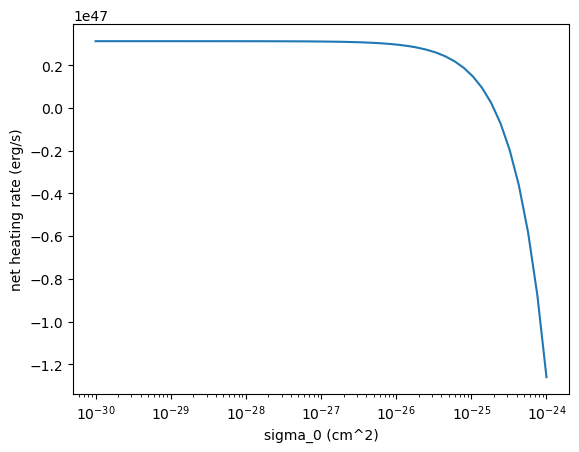

In [176]:
sig_0=np.logspace(-30, -24)*u.cm**2
plt.plot(sig_0,equil(cls.baryon_temp, cls, sig_0))
plt.xscale('log')

plt.xlabel('sigma_0 (cm^2)')
plt.ylabel('net heating rate (erg/s)')

In [177]:
equil(cls.baryon_temp, cls, 0*u.cm**2)

<Quantity 3.12811475e+46 GeV / s>

In [424]:
#prepare MCMC
ndim, nwalkers = 1, 10
p0=np.zeros((nwalkers, ndim ))
log_sigma0 = np.random.uniform(low=-50, high=0, size=nwalkers).astype(np.float128)
p0[:,0]=log_sigma0
p0

array([[ -3.45960991],
       [-31.25966466],
       [-22.72725444],
       [-31.45373934],
       [-46.73834741],
       [ -7.42929845],
       [-23.37795747],
       [-24.80170299],
       [-23.80764417],
       [-20.78830203]])

In [425]:
T_data = [c.baryon_temp for c in clusters]

In [426]:
def log_lik(p0, T_data, var, clusters, m_chi):
    if p0<-50 or p0>0:
        return -np.inf
    #print(p0)
    T_model = [brentq(equil, -15, 0, args=(c, p0, m_chi)) for c in clusters]
    X2 = chi_squared(np.power(10,T_model)*u.GeV, T_data, var)
    return (-X2/2)

In [427]:
log_lik(-25, T_data, variances, clusters, -2)

<Quantity -11174.68834864>

In [428]:
m_chi=-2
n=0
sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_lik, 
    args=[T_data, variances, clusters, m_chi])

In [429]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

100%|█████████████████████████████████████████| 100/100 [09:33<00:00,  5.73s/it]


In [430]:
sampler.run_mcmc(state, 1000, progress=True)

100%|█████████████████████████████████████| 1000/1000 [4:30:11<00:00, 16.21s/it]


State([[-23.8584047 ]
 [-23.8637239 ]
 [-23.86545534]
 [-23.86127661]
 [-23.86858153]
 [-23.88304233]
 [-23.88592506]
 [-23.86312365]
 [-23.87339468]
 [-23.86701753]], log_prob=[-234.49270613 -234.19011909 -234.1402332  -234.30143433 -234.11107678
 -235.01072656 -235.3964576  -234.21300514 -234.22054776 -234.11583937], blobs=None, random_state=('MT19937', array([1655803623, 1066582170, 2866689165, 3833472595, 1999226913,
       1102719920,  310968298, 2312592332, 3829820861, 1498003261,
         13121229, 3794808391, 4048518247, 3346931374, 1457214193,
       3438498351, 3640472099, 2834249603, 3109436222,   27551395,
       3703201502, 1078117004,  459999937, 3382578842, 3831807498,
       2909538364, 1955142894, 3638024333, 4120962341, 1123943979,
        155649139, 1313485477,  486372755, 1104515254, 4140717867,
       1664287799, 3096760011,  836871972, 3451605818, 1218064678,
       1217601860, 3050201561,  249611805, 2516291307,  279339650,
       1286963914, 1215962540, 16762007

In [431]:
samples = sampler.get_chain(flat=True)

In [432]:
"Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.803'

(10000, 1)


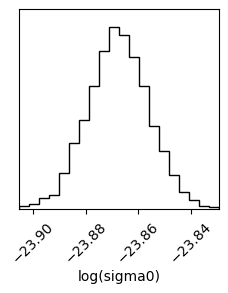

In [433]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log(sigma0)'])

In [434]:
np.median(samples)

-23.867796514320826

In [435]:
flat_samples

array([[-23.866556  ],
       [-23.85751349],
       [-23.85889296],
       ...,
       [-23.86312365],
       [-23.87339468],
       [-23.86701753]])

In [436]:
samples=sampler.get_chain()

In [437]:
samples.shape

(1000, 10, 1)

In [438]:
samples[4]

array([[-23.86741281],
       [-23.84367502],
       [-23.86593261],
       [-23.86450544],
       [-23.84720075],
       [-23.84804585],
       [-23.87006051],
       [-23.87897019],
       [-23.8717391 ],
       [-23.86979016]])